# Milestone 2

This notebook contains machinmachinmachin, blabla happy reading ihihihihihi

In [ ]:
import sys
import os
import os.path as op
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import gzip
import warnings
from tqdm.notebook import tqdm

from googleapiclient.discovery import build
from googleapiclient.errors import HttpError



from config import DRIVE_PATH_VIVA, DRIVE_PATH_FLORIAN

sys.path.insert(0, '.') # to use relative paths
path_data = op.join('data', 'raw')
path_deriv = op.join(path_data, '..', 'derivatives')
path_exploration_fig = os.path.join('data', 'figures', 'exploration')
path_edu = op.join(path_deriv, "Education_videos_{}.csv")

RAW_DATA_PATH = op.join(path_data, "yt_metadata_en.jsonl.gz") # change here to your data path !!!
warnings.filterwarnings("ignore")

In [ ]:
# TODO delete dans le final 
%load_ext autoreload
%autoreload 2

## Data Extraction

In [5]:
# The proper extraction
category = 'Education'
video_file_path = os.path.join(RAW_DATA_PATH, f'extracted_{category}', 'yt_metadata_en.jsonl.gz')
save_path = os.path.join(path_deriv) # change so you save it wherever you like

total_len = 3795564 # 3'795'564 (info obtained from metadata_subcategories.ipynb)
approx_length = round(total_len/1000000,1)*1000000 
N_BATCHES = 8
batch_size = int(np.floor_divide(approx_length,N_BATCHES)) # for 8 batches should end up with 475'000

#filter_jsonl(video_file_path, category, batch_size, save_path, verbose=True) # lengthy process do not call

## Bert pipeline for assigning subcategories to Education videos

## Bart pipeline for assigning subcategories to Education videos

In [ ]:
# TODO Code de Florian a modifier eventuellement 
from utils import load_metadata_videos, bart_classification, plot_scores_BART
file_path = path_edu.format(5) # DRIVE_PATH_FLORIAN
df_education = load_metadata_videos(file_path)

In [ ]:
from config import purpose_labels, level_labels, content_labels

sample_row = 364772
title = df_education.loc[sample_row, 'title']
tags = df_education.loc[sample_row, 'tags']
combined_text = f"{title} {tags.replace(',', ', ')}"
print('Row:', sample_row)
print('Title:', title)
print('Tags:', tags)
purpose = bart_classification(combined_text, purpose_labels, multi_label=True, plot=True, title=title)
print("--> Purpose:", purpose)
level = bart_classification(combined_text, level_labels, multi_label=False, plot=True, title=title)
print("--> Level:  ", level)
content = bart_classification(combined_text, content_labels, multi_label=True, plot=True, title=title)
print("--> Content:", content)

# Country extraction from YouTube Data API v3

In [ ]:
from utils import extract_channels_edu

channels = extract_channels_edu(path_edu, N_BATCHES, verbose = True)

Processing file : path_edu_0  --> Found 3412 channels
Processing file : path_edu_1  --> Found 3039 channels
Processing file : path_edu_2  --> Found 3069 channels
Processing file : path_edu_3  --> Found 3036 channels
Processing file : path_edu_4  --> Found 3384 channels
Processing file : path_edu_5  --> Found 3282 channels
Processing file : path_edu_6  --> Found 3150 channels
Processing file : path_edu_7  --> Found 3224 channels
Total number of channels : 25587


In [ ]:
from utils import youtube_country_scraper

countries = pd.DataFrame(columns = ['channel_id', 'country']) 
countries['channel_id'] = channels
countries['country'] = 'empty'

start = 0
end = len(countries) # max 10k per day - improved since now we do batches so can run all of them in one go
batch_size = 50 # max youtube allows per request

try:
    for i in tqdm(range(start,end,batch_size), total = (end - start)//batch_size, desc = 'Country extraction'):
        chs = channels[i:min(i+batch_size,end)]
        nations = youtube_country_scraper(chs, verbose= False)
        
        for ch in chs:
            countries.loc[countries.channel_id == ch, 'country'] = nations[ch]
            tqdm.write('Channel {} : {} - {}  '.format(i, ch, nations[ch]), end="\r")

    if end % batch_size != 0:
        chs_extra = channels[(end//batch_size)* batch_size:end]
        nations = youtube_country_scraper(chs_extra, verbose= False)
        for i, ch in enumerate(chs_extra):
            countries.loc[countries.channel_id == ch, 'country'] = nations[ch]
            tqdm.write('Channel {} : {} - {}  '.format(i, ch, nations[ch]), end="\r")

except HttpError as e:
        if e.resp.status == 403:
            print('Quota exceeded, saving extracted countries')
            countries.to_csv(op.join(path_deriv, 'countries.csv'), index = False)        

countries.to_csv(op.join(path_deriv, 'countries.csv'))
tqdm.write('Done!                                        ')

In [ ]:
# Redo the ones that could not be identified in the response to the api request - most of them are deleted channels
countries_redo = countries[countries.country == 'deleted'].reset_index(drop = True) 
for i, ch in tqdm(enumerate(countries_redo.channel_id), total = len(countries_redo)//10, desc = 'Countries redo'):
    nations = youtube_country_scraper([ch], verbose= False)
    countries.loc[countries.channel_id == ch, 'country'] = nations[ch]
    tqdm.write('Channel {} : {} - {}  '.format(i, ch, nations[ch]), end="\r")

countries.to_csv(op.join(path_deriv, 'countries.csv'))

In [15]:
# Run from here on extracted data
countries = pd.read_csv(op.join(path_deriv, 'countries.csv'))

In [16]:
#group in single category all the countries with less than 10 channels
from utils import agglomerate_countries

filter = 20
countries_plt = countries.copy()
countries_plt['country'] = countries_plt['country'].apply(agglomerate_countries, args=(countries_plt['country'].value_counts(),filter))

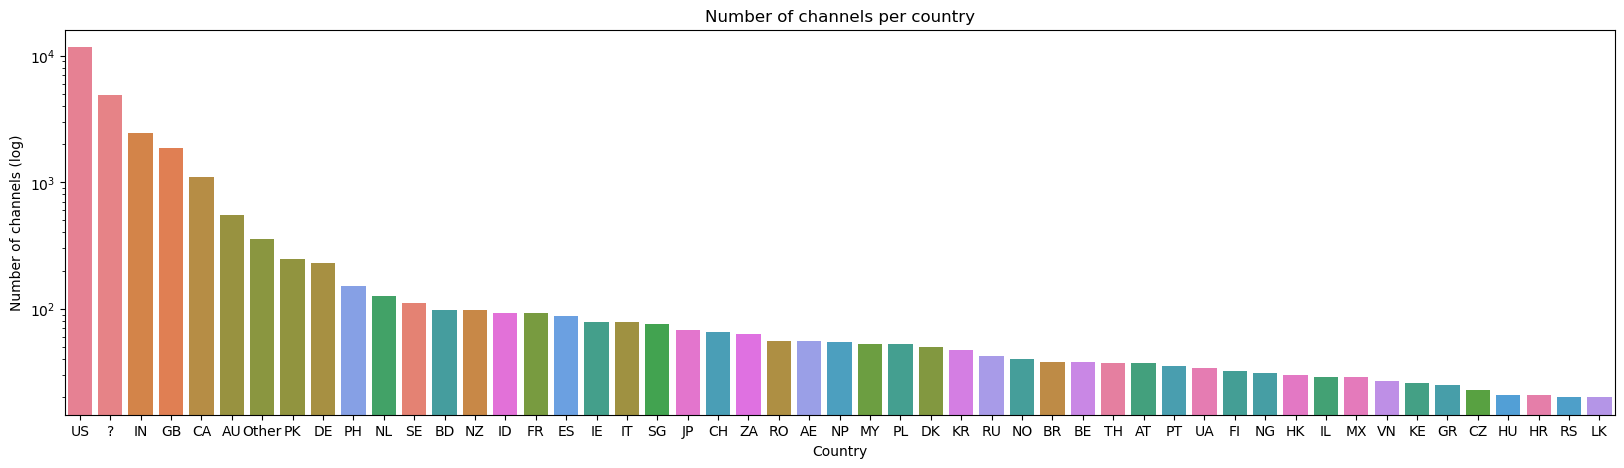

In [17]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.countplot(x='country', data=countries_plt, order = countries_plt['country'].value_counts(dropna=False).index, hue = 'country', ax=ax)
ax.set_yscale('log')
ax.set_title('Number of channels per country')
ax.set_xlabel('Country')
ax.set_ylabel('Number of channels (log)')
plt.show()
# ax.legend_.remove()